# **Project: Amazon Product Recommendation System**

# **Marks: 40**


Welcome to the project on Recommendation Systems. We will work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model.

--------------
## **Context:**
--------------

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business.

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
## **Objective:**
----------------

You are a Data Science Manager at Amazon, and have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. You have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:**
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem

**Note:** The code has some user defined functions that will be usefull while making recommendations and measure model performance, you can use these functions or can create your own functions.

Sometimes, the installation of the surprise library, which is used to build recommendation systems, faces issues in Jupyter. To avoid any issues, it is advised to use **Google Colab** for this project.

Let's start by mounting the Google drive on Colab.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir("/content/drive/MyDrive")

**Installing surprise library**

In [3]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 1.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357253 sha256=a3de46802b8fdc05cd88d7b2f95d441e9ea2090994fe7e51e339e7d961d5f578
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


## **Importing the necessary libraries and overview of the dataset**

In [4]:
# Used to ignore the warning given as output of the code
import warnings
warnings.filterwarnings('ignore')

# Basic library for data visualization
import matplotlib.pyplot as plt

# Slightly advanced library for data visualization
import seaborn as sns

# A dictionary output that does not raise a key error
from collections import defaultdict

# A performance metrics in sklearn
from sklearn.metrics import mean_squared_error

from surprise import accuracy
from surprise.reader import Reader
from surprise.dataset import Dataset
from surprise.model_selection import GridSearchCV
from surprise.model_selection import train_test_split
from surprise.prediction_algorithms.knns import KNNBasic
from surprise.prediction_algorithms.matrix_factorization import SVD
from surprise.model_selection import KFold
from surprise import CoClustering
import warnings

#Used to ignore the warning given as output of the code.
warnings.filterwarnings('ignore')

import numpy as np # Basic libraries of python for numeric and dataframe computations.
import pandas as pd

from sklearn.metrics.pairwise import cosine_similarity #To compute the cosine similarity between two vectors.


### **Loading the data**
- Import the Dataset
- Add column names ['user_id', 'prod_id', 'rating', 'timestamp']
- Drop the column timestamp
- Copy the data to another DataFrame called **df**

In [5]:
df_in = pd.read_csv('/content/drive/My Drive/ColabNotebooks/project 3/ratings_Electronics.csv')
df_in.columns = ['user_id', 'prod_id', 'rating', 'timestamp']
df = df_in.drop('timestamp', axis = 1)
df.shape

(7824481, 3)

**As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product.

In [6]:
# Get the column containing the users
users = df.user_id

# Create a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [7]:
# We want our users to have at least 50 ratings to be considered
RATINGS_CUTOFF = 50

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df = df.loc[ ~ df.user_id.isin(remove_users)]

In [8]:
# Get the column containing the products
prods = df.prod_id

# Create a dictionary from products to their number of ratings
ratings_count = dict()

for prod in prods:

    # If we already have the product, just add 1 to its rating count
    if prod in ratings_count:
        ratings_count[prod] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[prod] = 1

In [9]:
# We want our item to have at least 5 ratings to be considered
RATINGS_CUTOFF = 5

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df_final = df.loc[~ df.prod_id.isin(remove_users)]

In [10]:
# Print a few rows of the imported dataset
df_final.head()

,user_id,prod_id,rating
1309,A3LDPF5FMB782Z,1400501466,5.0
1321,A1A5KUIIIHFF4U,1400501466,1.0
1334,A2XIOXRRYX0KZY,1400501466,3.0
1450,AW3LX47IHPFRL,1400501466,5.0
1455,A1E3OB6QMBKRYZ,1400501466,1.0


## **Exploratory Data Analysis**

### **Shape of the data**

### **Check the number of rows and columns and provide observations.**

In [11]:
# Check the number of rows and columns and provide observations
df_final.shape

(65290, 3)

the size was cut drastically, only about .0083 % of data was left after the cutoff

there are 65290 observations left after the cut off

### **Data types**

In [12]:
# Check Data types and provide observations
df_final.dtypes

user_id     object
prod_id     object
rating     float64
dtype: object

user and product id are both objects while the rating is a float. so two catagorical data types and one numerical.

### **Checking for missing values**

In [13]:
# Check for missing values present and provide observations
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 65290 entries, 1309 to 7824426
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  65290 non-null  object 
 1   prod_id  65290 non-null  object 
 2   rating   65290 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.0+ MB


there are 65290 non null values for each so there are 0 null/missing values



### **Summary Statistics**

In [14]:
# Summary statistics of 'rating' variable and provide observations
df_final['rating'].describe()

count    65290.000000
mean         4.294808
std          0.988915
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: rating, dtype: float64

the mean is 4.295 which is a high mean for a scale of 0-5.

at least 50% of the ratings are 5s do the data is skewed to the higher end of the scale. you can also tell this since the mean is less than the median

### **Checking the rating distribution**

<Axes: xlabel='rating'>

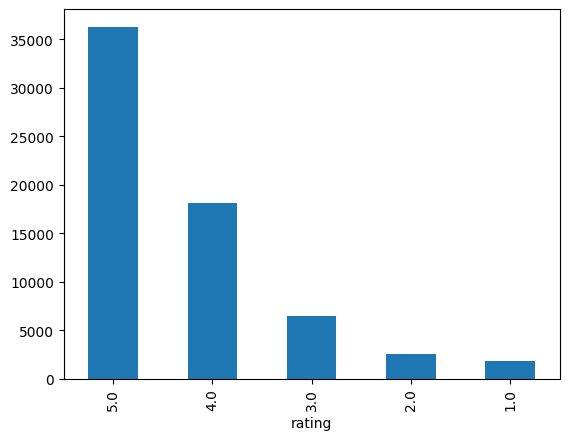

In [15]:
# Create the bar plot and provide observations
df_final['rating'].value_counts().plot(kind = 'bar')

like we assumed, it is very skewed to the higher part of the scale, with majority of the observations in the 4-5 range. very few rating in the 1-2 range

### **Checking the number of unique users and items in the dataset**

In [16]:
# Number of total rows in the data and number of unique user id and product id in the data
df_final.shape, df_final.user_id.nunique(), df_final.prod_id.nunique()

((65290, 3), 1540, 5689)

*out of all 65290 rows, only 1540 users are unique and 5689 products are unique

### **Users with the most number of ratings**

In [17]:
# Top 10 users based on the number of ratings
df_final.user_id.value_counts().head(10)

user_id
ADLVFFE4VBT8      295
A3OXHLG6DIBRW8    230
A1ODOGXEYECQQ8    217
A36K2N527TXXJN    212
A25C2M3QF9G7OQ    203
A680RUE1FDO8B     196
A1UQBFCERIP7VJ    193
A22CW0ZHY3NJH8    193
AWPODHOB4GFWL     184
AGVWTYW0ULXHT     179
Name: count, dtype: int64

ADLVFFE4VBT8      295

A3OXHLG6DIBRW8    230

A1ODOGXEYECQQ8    217

A36K2N527TXXJN    212

A25C2M3QF9G7OQ    203

A680RUE1FDO8B     196

A1UQBFCERIP7VJ    193

A22CW0ZHY3NJH8    193

AWPODHOB4GFWL     184

AGVWTYW0ULXHT     179

these are the top ten, with ADLVFFE4VBT8 having the most ratings are 295 ratings

**Now that we have explored and prepared the data, let's build the first recommendation system.**

## **Model 1: Rank Based Recommendation System**

In [18]:
# Calculate the average rating for each product
avg = df_final.groupby('prod_id')['rating'].mean()

# Calculate the count of ratings for each product
count = df_final.groupby('prod_id')['rating'].count()
# Create a dataframe with calculated average and count of ratings
rank_based_df = pd.DataFrame({'avg_rating':avg, 'rating_count':count})

# Sort the dataframe by average of ratings in the descending order
rank_based_df = rank_based_df.sort_values(by = 'avg_rating', ascending = False)

# See the first five records of the "final_rating" dataset
rank_based_df.head(5)

,avg_rating,rating_count
prod_id,,
B00LGQ6HL8,5.0,5
B003DZJQQI,5.0,14
B005FDXF2C,5.0,7
B00I6CVPVC,5.0,7
B00B9KOCYA,5.0,8


In [19]:
# Defining a function to get the top n products based on the highest average rating and minimum interactions
def top_n_products(df,n,min_interactions):
# Finding products with minimum number of interactions
    recommendations = df[df['rating_count'] >= min_interactions]
# Sorting values with respect to average rating
    recommendations = recommendations.sort_values(by = 'avg_rating', ascending = False)
# Getting top n recommendations
    recommendations = recommendations.iloc[:n]
    return recommendations

### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [20]:
top_n_products(rank_based_df,5,50)

,avg_rating,rating_count
prod_id,,
B001TH7GUU,4.871795,78
B003ES5ZUU,4.864130,184
B0019EHU8G,4.855556,90
B006W8U2MU,4.824561,57
B000QUUFRW,4.809524,84


### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [21]:
top_n_products(rank_based_df,5,100)

,avg_rating,rating_count
prod_id,,
B003ES5ZUU,4.864130,184
B000N99BBC,4.772455,167
B002WE6D44,4.770000,100
B007WTAJTO,4.701220,164
B002V88HFE,4.698113,106


overall this rank based system give a good highlevel suggestion precoess based on two factors. rating average and rating count. you sort by average for quality of product and you filter those with now amount of ratings to ensure teh rating is reliable.

We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [22]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them.

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [23]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    accuracy.rmse(predictions)

    print('Precision: ', precision) # Command to print the overall precision

    print('Recall: ', recall) # Command to print the overall recall

    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

**Hints:**

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 can be considered for the recommended and relevant ratings**.
- Think about the performance metric to choose.

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [24]:
from csv import reader
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale = (0, 5))
# Loading the rating dataset
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)
# Splitting the data into train and test datasets
trainset, testset = train_test_split(data, test_size = 0.20)

Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

### **Building the user-user Similarity-based Recommendation System**

In [25]:
# Declaring the similarity options
sim_options = {'name': 'cosine', 'user_based': True}

# Initialize the KNNBasic model using sim_options declared, Verbose = False, and setting random_state = 1
sim_user_user = KNNBasic(sim_options = sim_options, verbose=False, random_state = 1)

# Fit the model on the training data
sim_user_user.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function defined above
precision_recall_at_k(sim_user_user)

RMSE: 1.0057
Precision:  0.857
Recall:  0.862
F_1 score:  0.859


the **rmse** is **1.0057** which means the predictions will be 1.0057 away from the actual on average

the **precision** was .**857** which means that 85.7 percent of recommendations made were actually relevent. this is a decent amount

the **recall** was **.862** which means that 86.2% of all possible relevent items were actually recommended. this is also decent, but that means **13.8% of relevent items were not recommended**.

the overall **harmonic mean** is **85.9%** which is pretty high, showing a decently reliable model

Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5.

In [26]:
# Predicting rating for a sample user with an interacted product
sim_user_user.predict('A3LDPF5FMB782Z', '1400501466', verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = None   est = 3.00   {'actual_k': 5, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=None, est=3.0, details={'actual_k': 5, 'was_impossible': False})

estimation was a 3.00 which is not very close to the actual rating of 5, so we will need to improve this


Below is the **list of users who have not seen the product with product id "1400501466"**.

In [27]:
df_final[df_final['prod_id'] != '1400501466']['user_id']

2081       A2ZR3YTMEEIIZ4
2149       A3CLWR1UUZT6TG
2161        A5JLAU2ARJ0BO
2227       A1P4XD7IORSEFN
2362       A341HCMGNZCBIT
                ...      
7824422    A34BZM6S9L7QI4
7824423    A1G650TTTHEAL5
7824424    A25C2M3QF9G7OQ
7824425     A1E1LEVQ9VQNK
7824426    A2NYK9KWFMJV4Y
Name: user_id, Length: 65284, dtype: object

* It can be observed from the above list that **user "A34BZM6S9L7QI4" has not seen the product with productId "1400501466"** as this userId is a part of the above list.

**Below we are predicting rating for `userId=A34BZM6S9L7QI4` and `prod_id=1400501466`.**

In [28]:
# Predicting rating for a sample user with a non interacted product
sim_user_user.predict('A34BZM6S9L7QI4', '1400501466', verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 3.00   {'actual_k': 1, 'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=3.0, details={'actual_k': 1, 'was_impossible': False})

the estimation was 3 which is pretty far off the previous person who rated it a 5. but this was made of the data of only one neighbor so teh insufficient neighbors could be the reason for the inaccurate prediction

### **Improving similarity-based recommendation system by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise -
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [29]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [10, 20, 30, 40], 'min_k': [1, 3, 6, 9], 'sim_options' : {'name': ['msd', 'cosine', 'pearson', "pearson_baseline"], "user_based": [True]}}

# Performing 3-fold cross-validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures = ['rmse'], cv = 3)
# Fitting the data
gs.fit(data)

# Find the best RMSE score
print(gs.best_score['rmse'])

# Find the combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done 

Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters**.

Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [30]:
# Using the optimal similarity measure for user-user based collaborative filtering
sim_options = {'name': 'msd', 'user_based': True}
# Creating an instance of KNNBasic with optimal hyperparameter values
sim_user_user_optimized = KNNBasic(sim_options = sim_options, k = 40, min_k=6, verbose = False, random_state = 1)
# Training the algorithm on the trainset
sim_user_user_optimized.fit(trainset)
# Let us compute precision@k and recall@k also with k =10
precision_recall_at_k(sim_user_user_optimized)

RMSE: 0.9580
Precision:  0.848
Recall:  0.895
F_1 score:  0.871


the F_1 score increase to .871 because the recall had a large increase to 89.5% and precision increased slightly to 84.8%/

the rmse also decreased to .9580  

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [31]:
# Use sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466
sim_user_user_optimized.predict('A3LDPF5FMB782Z', '1400501466', verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=None, est=4.293077040894471, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

In [32]:
# Use sim_user_user_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
sim_user_user_optimized.predict('A34BZM6S9L7QI4', '1400501466', verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.293077040894471, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

Here it acknowledges that there is a insufficient number of neighbors for a sufficient prediction. instead it returned the average for the ratings for the item.

but regardless, the prediction was closer to the correct rating for user A3LDPF5FMB782Z as it was about 4.29 and the average this user gave was a 5. so i would assume these predictions are better even though they fall back to rank.

### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [33]:
# 0 is the inner id of the above user
sim_user_user_optimized.get_neighbors(0, 5)

[7, 13, 16, 28, 34]

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [34]:
def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')

    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:

        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est

        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [35]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
recs = get_recommendations(df_final, 'A3LDPF5FMB782Z', 5, sim_user_user_optimized)

In [36]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recs, columns = ['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,B000V1MLBE,5
1,B00316263Y,5
2,B003ES5ZR8,5
3,B004RORMF6,5
4,B005ES0YYA,5


### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**.

In [37]:
# Declaring the similarity options
sim_options = {'name': 'cosine', 'user_based':False}
# KNN algorithm is used to find desired similar items. Use random_state=1
sim_item_item = KNNBasic(sim_options = sim_options, random_state = 1, verbose = False)
# Train the algorithm on the trainset, and predict ratings for the test set
sim_item_item.fit(trainset)
# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(sim_item_item)

RMSE: 1.0155
Precision:  0.834
Recall:  0.843
F_1 score:  0.838


the **rmse** is **1.0155** which means the predictions will be 1.0155 away from the actual on average

the **precision** was .**834** which means that 83.4 percent of recommendations made were actually relevent. this is a decent amount

the **recall** was **.843** which means that 86.2% of all possible relevent items were actually recommended. this is also decent, but that means **15.7 of relevent items were not recommended**.

the overall **harmonic mean** is **83.8%** which is pretty high, showing a decently reliable model. but this model was worse than the user user model

Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [38]:
# Predicting rating for a sample user with an interacted product
sim_item_item.predict('A3LDPF5FMB782Z', '1400501466', verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = None   est = 4.30   {'actual_k': 20, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=None, est=4.3, details={'actual_k': 20, 'was_impossible': False})

this is a solid prediction. it is 4.30 when the actual was 5, and it based the prediction on 20 neighbors so it had sufficient data to pull from

Below we are **predicting rating for the `userId = A34BZM6S9L7QI4` and `prod_id = 1400501466`**.

In [39]:
# Predicting rating for a sample user with a non interacted product
sim_item_item.predict('A34BZM6S9L7QI4', '1400501466', verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.60   {'actual_k': 5, 'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.6, details={'actual_k': 5, 'was_impossible': False})

4.6 is also a good prediction because it is in the higher rating range which seems to be the concensus for other users

### **Hyperparameter tuning the item-item similarity-based model**
- Use the following values for the param_grid and tune the model.
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure
- Print the best score and best parameters

In [40]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [10, 20, 30], 'min_k': [3, 6, 9], 'sim_options' : {'name': ['msd', 'cosine'], "user_based": [False]}}
# Performing 3-fold cross validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures = ['rmse'], cv = 3)
# Fitting the data
gs.fit(data)
# Find the best RMSE score
print(gs.best_score['rmse'])
# Find the combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matr

Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above.**

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

### **Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model. Compare the performance of the optimized model with the baseline model.**

In [41]:
# Using the optimal similarity measure for item-item based collaborative filtering
sim_options = {'name': 'msd', 'user_based':False}
# Creating an instance of KNNBasic with optimal hyperparameter values
sim_item_item_optimized = KNNBasic(sim_options = sim_options, k = 30, min_k=6, verbose = False, random_state = 1)
# Training the algorithm on the trainset
sim_item_item_optimized.fit(trainset)
# Let us compute precision@k and recall@k, f1_score and RMSE
precision_recall_at_k(sim_item_item_optimized)

RMSE: 0.9630
Precision:  0.838
Recall:  0.89
F_1 score:  0.863


the **rmse** is **.9630** which means the predictions will be .9630 away from the actual on average

the **precision** was .**838** which means that the precision increased by .004.

the **recall** was **.89** which means recall increased by .047. this is also decent, since it now means only 11% of relevent items werent recommended

the overall **harmonic mean** is **86.3%** which is pretty high, showing a decently reliable model. but it is still less than the user user optimized model.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [42]:
# Use sim_item_item_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
sim_item_item_optimized.predict('A3LDPF5FMB782Z', '1400501466', verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = None   est = 4.72   {'actual_k': 20, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=None, est=4.720911310008137, details={'actual_k': 20, 'was_impossible': False})

In [43]:
# Use sim_item_item_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
sim_item_item_optimized.predict('A34BZM6S9L7QI4', '1400501466', verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.293077040894471, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

here the prediction for the user A3LDPF5FMB782Z became more accurate, showing that the prediction is now 4.72 when the original was 4.3. and the actual rating was 5.

but the prediciton for the user A34BZM6S9L7QI4 ran into the same problem as before with a lack of neighbors, so it returned the global average of the product. but this was still almost exactly what we predicted before so it seems reliable

### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

In [44]:
sim_item_item_optimized.get_neighbors(0, 5)

[139, 150, 158, 169, 172]

**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**

**Hint:** Use the get_recommendations() function.

In [45]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
recs = get_recommendations(df_final, 'A1A5KUIIIHFF4U', 5, sim_item_item_optimized)

In [46]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recs, columns = ['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,1400532655,4.293077
1,1400599997,4.293077
2,9983891212,4.293077
3,B00000DM9W,4.293077
4,B00000J1V5,4.293077


Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

### **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [47]:
# using SVD matrix factorization
svd = SVD(random_state=1)

# training the algorithm on the trainset
svd.fit(trainset)

# Let us compute precision@k and recall@k with k =30.
precision_recall_at_k(svd)

RMSE: 0.8927
Precision:  0.85
Recall:  0.878
F_1 score:  0.864


the **rmse** is **.8927** which means the predictions will be .8927 away from the actual on average

the **precision** was .**85** which means that 85 percent of recommendations made were actually relevent. this is a decent amount

the **recall** was **.878** which means that 87.8% of all possible relevent items were actually recommended. this is also decent, but that means **12.2 of relevent items were not recommended**.

the overall **harmonic mean** is **86.4%** which is pretty high, showing a decently reliable model.

**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [48]:
# Making prediction
svd.predict('A3LDPF5FMB782Z', '1400501466', verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = None   est = 4.11   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=None, est=4.114227956918791, details={'was_impossible': False})

the prediction here was worse than the item item simulation but better than the user user. at 4.11 this is not a bad prediciton although the real rating was 5. this refects the rmse well

**Below we are predicting rating for the `userId = "A34BZM6S9L7QI4"` and `productId = "1400501466"`.**

In [49]:
# Making prediction
svd.predict('A34BZM6S9L7QI4', '1400501466', verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.15   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.146313097587706, details={'was_impossible': False})

this is a little lower that the item_item at 4.15 but not far off teh average for the product and is a more personal reflection of ratings

### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [50]:
# Set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}

# performing 3-fold gridsearch cross validation
gs_ = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# fitting data
gs_.fit(data)

# best RMSE score
print(gs_.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs_.best_params['rmse'])

0.8985518292067788
{'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.2}


Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [55]:
# building the optimized SVD model using optimal hyperparameter search
svd_optimized = SVD(n_epochs=20, lr_all=0.01, reg_all=0.2, random_state=1)

# training the algorithm on the trainset
svd_optimized=svd_optimized.fit(trainset)

# Let us compute precision@k and recall@k also with k =30.
precision_recall_at_k(svd_optimized)

RMSE: 0.8836
Precision:  0.851
Recall:  0.878
F_1 score:  0.864


the **rmse** is **.8836** which is a improvement from the previous model

the **precision** was .**851** which is not much different from the previous model

the **recall** was **.878** which is not different from teh previous model

the overall **harmonic mean** is **86.4%** which is the same as the last model although is still solid.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [56]:
# Use svd_algo_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
svd_optimized.predict('A3LDPF5FMB782Z', '1400501466', verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = None   est = 4.04   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=None, est=4.040738702347228, details={'was_impossible': False})

In [57]:
# Use svd_algo_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
svd_optimized.predict('A34BZM6S9L7QI4', '1400501466', verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 3.98   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=3.9759295136138193, details={'was_impossible': False})

the predictions seemed to get lower which moved away from the actual rating of the item by user A3LDPF5FMB782Z. this could suggest that the actual rating of the item is lower or that this high of a rating for this user is unusual.

### **Conclusion and Recommendations**

in this study we created 4 recommendation systems useing various algorithms. rank based, user user, item item, and model based for personal recommendations.

all of these seemed to have similar *rmse's* and F1 scores, but out of all of them, we saw that the **user user system** had a **higher F1 than the rest**. by this logic, and considering its rmse wasnt much different than the rest **you could assume this model is more reliable and robust**.

after testing with this data specifically, it would seem that **item_item gave the most accurate results after classification analysis**, and considering the fact that it had enough neighbors to make quality predictions.

**if the data is large/quality enough**, i would use the **user user model**, but for this data i would use the item_item, as it had enough neighbors and the SVD seemed to make low preditcions

In [62]:
!pip install nbconvert
%cd "/content/drive/My Drive/ColabNotebooks/project 3"
!jupyter nbconvert --to html redo_Recommendation_Systems_Learner_Notebook_Full_Code.ipynb

/content/drive/My Drive/ColabNotebooks/project 3
[NbConvertApp] Converting notebook redo_Recommendation_Systems_Learner_Notebook_Full_Code.ipynb to html
[NbConvertApp] Writing 841316 bytes to redo_Recommendation_Systems_Learner_Notebook_Full_Code.html
